# Credit Card Approval Model using XGBoost

### Overiew



Credit Card department in a bank is a leading data science adopter. Acquiring new credit card users is always a key priority for the bank. Giving credit cards without due diligence or assessment for creditworthiness is a huge risk.

From the last many decades, the credit card department is using a data-driven credit assessment methodology called Credit Scoring, and the model is called application scorecard. The application scorecard helps in the calculating level of risk associated with an applicant and based on strategic priority at a time, they decide the cut off value of the score for approving or rejecting a credit card application.

Mostly, Logistic Regression is used as modeling techniques in credit scorecard development as the banks are required to provide justification if a customer demands justification around the decision.

Though, in this blog, we will use the XGBoost method for predicting credit card approval decisions. The defining target variable, data preparation, exploratory data analysis (EDA), Model Building using XGBoost, Fine Tuning Parameters, and Validating Model are some of the key steps followed for developing Credit Card Approval Model.


## Data

Source: https://www.kaggle.com/rikdifos/credit-card-approval-prediction/tasks?taskId=1416

Two files are available. One, the application data, and the second one monthly credit card account status information.

The application data will be used for feature creation. And the status (credit payment status) will be required for defining the labels - which of the applications have paid back dues and which of these turn out to bad accounts.

### 1. Application

For a credit card, the customers fill-up the form - online or a physical. The application information is used for assessing the creditworthiness of the customer. In addition to the application information, the Credit Bureau Score e.g. FICO Score in the US, CIBIL Score in India, and other internal information about the applicants are used for the decision.

Also, gradually the banks are considering a lot of external data to improve the quality of credit decisions.

Now, we will read and explore the application sample data file provided.

In [ ]:
import pandas as pd
# read data
application = pd.read_csv("../input/credit-card-approval-prediction/application_record.csv")

We may want to validate the data read. Row count and feature/variable type are important for validating the data. Also, it is typically useful to view the first/last few rows. We can use info() and head()/tail() methods.

In [ ]:
application.info()

In [ ]:
application.head()

Data Dictionary: Meaning of variables and their values. 

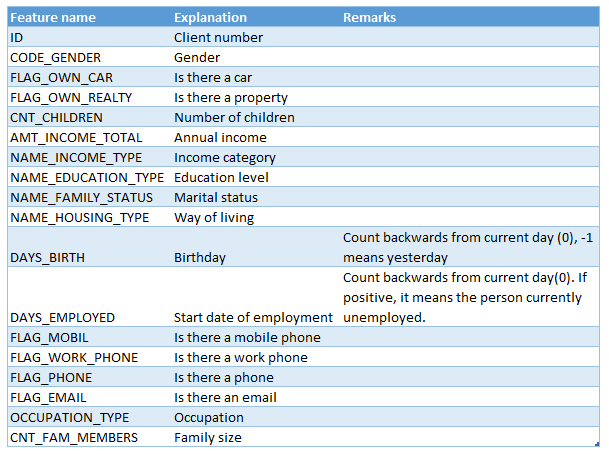

#### Summary Statistics

Summary statistics for each of the numeric features gives insights around the feature value distribution. 

In [ ]:
application.describe()

**Key observations** from the summary statistics are:

- **FLAG_MOBIL** : Min and Max values are same, so may not be of any use.
- **CNT_FAM_MEMBERS**: Max value is 20 and 75th percentile is 3, so we may want to check for outliers.

Some of the flag variables have 0 value for 75th percentile, so we may check the count/percentage for 1 & 0 values for these.


### 2. Credit Status

Once a credit card is issued, the customer uses it for shopping items of its use, a statement is generated to make a payment toward the dues by due date and the customer makes payment. This is a typical credit card cycle.

If a customer is not able to make a payment for the minimum due amount, the customer is considered past due for that month.
If the non-payment is continued for a period, the customer is considered as a defaulter and the due amount is written off & becomes bad debt. Of course, there is a lot of effort and steps the bank does to recover the due amount and this falls under the collection process.

With the modeling process, the aim to learn about the customers who were not able to pay back the dues and not to approve applications of the customers who look similar to these.
Of course, we do not know the applications that were rejected and how many of those were actually good customers. This is not in the scope of this blog.

For this exercise, the credit status file is given. In this file, the status value is given for each of the applications post approved.

In [ ]:
credit_status=pd.read_csv("../input/credit-card-approval-prediction/credit_record.csv")

In [ ]:
credit_status.columns

**ID**: The joining key between application data and credit status data

**MONTHS_BALANCE**:  The month of the extracted data is the starting point with 0 is the current month, -1 is the previous month, and so on

**STATUS**: Status of the credit card account. 
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month 
- X: No loan for the month


We may want to see the accounts by the **MONTHS_BALANCE**. Ideally, it would have been useful to get the application date or month. And the status value for each month post credit card open month. So, the credit behavior of the applicants across the application months can be compared.




In [ ]:
out_df =credit_status.groupby(['MONTHS_BALANCE']).agg(
    # Counts
    counts=('MONTHS_BALANCE', lambda x: len(x) ),
    # Percent
    percent = ('MONTHS_BALANCE', lambda x: (len(x)*100/ len(credit_status['MONTHS_BALANCE'])))
    ).reset_index()

In [ ]:
pd.pivot_table(out_df,index=['MONTHS_BALANCE'])

In [ ]:
# rows in Application Data
len(application)

In [ ]:
# rows in credit status
len(credit_status)

In [ ]:
app_credit_status= pd.merge(application,credit_status, how='inner', on='ID')
len(app_credit_status)

For each of the applicants - a row is available in the **Application** table. The credit status information for each of these applicants is available in the **credit_status** table. ID variable is the joining key between these two tables.

We joined these two tables using ID Variable, there is a drop in the number of rows from 1,048,575 to 777,715. This can only happen if ID variable values are not available in the Application table.

So, there is some gap in the data or our understanding of the data.

## Target Variable Creation

In a bank, once a credit card is approved, the account is tracked over a period to monitor the performance of an account and also the overall portfolio health.

For building an application scorecard, we need a label variable that takes values - Good or Bad- for each of the accounts based on the credit status of the accounts at the end of a period. Then, using available features at the time of application, the modeling technique helps us differentiate between the profiles of the Good and Bad segments.

For this analysis, the accounts which are overdue for a period of over 120 days (status 4 and 5) are considered as **Bad** and others as **Good**.

The bad rate for a period is calculated as % of overall accounts which are Bad Accounts.

Cohort or vintage analysis helps in tracking Bad Rates (% of accounts bad for that month) across months from the acquired month. This helps us in finding out the periods (# of months between account open month and status month) to be considered for defining the target variable. This period or window is called the **performance window**. For example, a scenario is depicted in the below diagram. The status is checked at the end of 6 months to define the target variable.

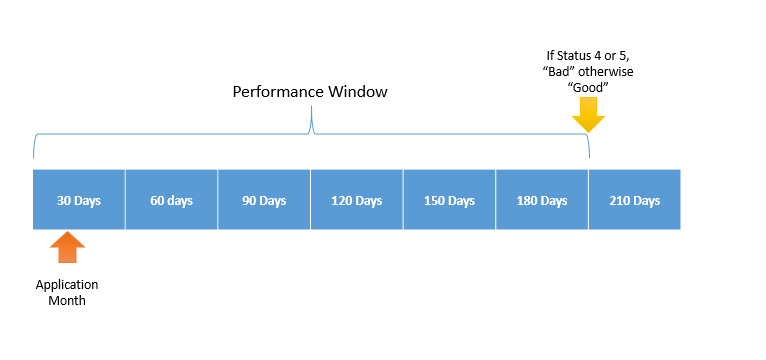

The current data file does not have credit card open date. Based on MONTHS_BALANCE, we will find the start month for each of the applicant. Then rearrange the data so that the status is available for month 0 (start month), month 1 (month 1 from the start) and so on.

We assume for the data the earliest **MONTHS_BALANCE** is the start month for an account. So, we aim to change the as per the below diagram
 

In [ ]:
# Earliest Month
credit_card_first_month =credit_status.groupby(['ID']).agg(
   start_month=  ('MONTHS_BALANCE', min)
    ).reset_index()

In [ ]:
credit_card_first_month.head()

We assume that the data were extracted as of 1-Jan-2020 and we are working on finding the calendar start month for each of the accounts. It may be useful to have the calendar account open date for a few analyses.


In [ ]:
import datetime
credit_card_first_month['account_open_month']= datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
credit_card_first_month['account_open_month']= credit_card_first_month['account_open_month'] + credit_card_first_month['start_month'].values.astype("timedelta64[M]")
credit_card_first_month['account_open_month']=credit_card_first_month['account_open_month'].dt.strftime('%b-%Y')

In [ ]:
credit_card_first_month.head()

Account 5001711 has been opened in Oct-2019 and the account 5001715 was opened in Jan-2015. We need to add the start month column to the credit status (credit_status) table. 

In [ ]:
# join the table
credit_start_status = pd.merge(credit_card_first_month, credit_status, how='left', on=['ID'])

credit_start_status['start_month']=abs(credit_start_status['start_month'])+credit_start_status['MONTHS_BALANCE']

In [ ]:
credit_start_status.head()

You can see the status by month since the start (start_month) and the relevance of what we have done.

Across all the acquisition months, now we can find portfolio performance across month 1, 2,5, 15, 20 months from their respective account open month. Distribution of account by the status across each of the months is calculated. First, we need to find the accounts by month and status code.

In [ ]:
accounts_counts =pd.DataFrame({'start_month':credit_start_status.groupby('start_month')['start_month'].count()})
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(accounts_counts.index,accounts_counts['start_month'])
plt.show()

We want to calculate % Bad Rate for the overall portfolio - across all the account open months. This will help us find the period by which the overall bad rate is stable.

Another important observation is that only a small volume of credit card accounts was opened in the early months. These accounts may not be relevant to consider for the modeling. We can check the Bad Rate distribution for these accounts.

In [ ]:
month_status_counts = credit_start_status.groupby(['start_month', 'STATUS']).size().reset_index(name='counts')
month_counts = credit_start_status.groupby(['start_month']).size().reset_index(name='month_counts')
# join the table
month_status_pct = pd.merge(month_status_counts, month_counts, how='left', on=['start_month'])
month_status_pct['status_pct']=month_status_pct['counts']/month_status_pct['month_counts']*100
month_status_pct= month_status_pct.loc[:,['start_month','STATUS','status_pct']]


In [ ]:
# Restucture
month_status_pct1 = month_status_pct.pivot(index='start_month', columns='STATUS', values='status_pct')
# Fill with 0
month_status_pct1=month_status_pct1.fillna(0).reset_index()

In [ ]:
import matplotlib.pyplot as pt
pt.plot(month_status_pct1.index, month_status_pct1['4']+month_status_pct1['5'],
     color='green', 
     linestyle='solid',
     linewidth=2, 
     markersize=12)
pt.xlabel('Months Since Opened')
pt.ylabel('% Bad Rate')

Bad Rate jump significantly for the accounts which are opened for over 50 months. There are the accounts that were opened for the initial days of the operations. It may not be a bad idea to exclude these accounts.

In [ ]:
month_status_pct2 = month_status_pct1.loc[month_status_pct1.index<=50]
# drop column start_month
month_status_pct2=month_status_pct2.drop('start_month', axis=1)

In [ ]:
import matplotlib.pyplot as plot
month_status_pct2.plot.area(stacked=True);
plot.show(block=True);

In [ ]:
import matplotlib.pyplot as pt
pt.plot(month_status_pct2.index, month_status_pct2['4']+month_status_pct2['5'],
     color='green', 
     linestyle='solid',
     linewidth=2, 
     markersize=12)

The bad rate is almost settled after 18 months from the start, we may decide to consider it as a performance window. Any of the accounts which become bad in the first 18 months, will be termed as **Bad** and rest as **Good**.

There may be a difference in performance - Bad rate % by acquisition month. But we are not it exploring that further.
Based on status 4 and 5 in the first 18 months, we will term as **Bad** and otherwise **Good**.

We will select start months less than 18 (so only the first 18 months are considered) and find max status for each of the credit card account. If the status is 4 or 5, we can call **Bad** otherwise **Good**.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
credit_start_status.groupby('STATUS')['STATUS'].count()
# We will remove rows with status as C and X
credit_start_status1 = credit_start_status.loc[ (credit_status['STATUS'] !='X') & (credit_status['STATUS'] !='C') ,:]
# Change status as numeric
credit_start_status1['status'] = credit_start_status1['STATUS'].astype('int64', copy=False)
credit_start_status1 = credit_start_status1.loc[credit_start_status1['start_month']<=18,['ID','start_month','status']]

In [ ]:
credit_start_status1

In [ ]:
# Find Max Status Values
status = credit_start_status1.groupby(['ID']).agg(
    # Max Status
    max_status=('status','max')

    ).reset_index()
# Validate
status.groupby('max_status')['max_status'].count()

In [ ]:
import numpy as np
# Define 
status['label']=np.where(status['max_status']>=4, 1,0)
# Validate
status.groupby('label')['label'].count()

In [ ]:
# Bad Rate 
status.groupby('label')['label'].count()*100/len(status['label'])


The data is highly unbalanced - with a bad rate of 0.47%. We can create a biased sample. Taking all observations of Label 1 but small % of observations from label 0. We may want to improve the bad rate to say 10%. So, in the final sample, we will 189 for label 1 and 1701 for label 0.

Now we want to select randomly 1701 observations from 39562.

In [ ]:
# All with label 1
label_1 = status.loc[status['label']==1,:]
# All with label 0
label_0 = status.loc[status['label']==0,:]
# Select randomly few rows
label_0_biased=label_0.sample(n = 1701) 
# Combined Sample IDs with Biased Sampling

frames = [label_1,label_0_biased]
import pandas as pd
labels_biased = pd.concat(frames)

# Keep only ID and Label Columns

labels_biased=labels_biased.loc[:,['ID','label']]

In [ ]:
labels_biased

Now, we have to combine application-level features to prepare model development data sample.

In [ ]:
# Combine Labels and Application Data
model_df = pd.merge (labels_biased, application,how='inner',on=['ID'] )
len(model_df)

**Observation**: There is a drop in the number of observations. We expected 1890 observations. This indicates that is a data issue between Application and Credit Status files shared.

In [ ]:
model_df.tail()

In [ ]:
model_df.groupby('label')['label'].count()*100/len(model_df['label'])

We are all set to proceed with data analysis and model development. Let's start with data exploration now.

## Data Exploration 

We have a list of Credit Card Applications features and Label variables. We want to understand the distribution of these variables, whether some of these variables have missing values.

Before proceeding further it may be a good starting point to see the type of variables.

In [ ]:
model_df.info()

In [ ]:
model_df.describe()

Let's check if any of the variables have missing values present.

In [ ]:
# Check if missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
# source: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe

missing_values_table(model_df)

Only Occupation Type is missing for 32% of the applicants. We can treat this as a separate class. Now we would want to see bivariate analysis - the analysis between Label variable and each of the feature variables. Based on the analytical type of the feature variables, the analysis may be different. So, we can find an analytical type of feature first. We have written a function to find the analytical type of variables.

In [ ]:
# Find Continuous and Categorical Features
def featureType(df):
    import numpy as np 
    from pandas.api.types import is_numeric_dtype

    columns = df.columns
    rows= len(df)
    colTypeBase=[]
    colType=[]
    for col in columns:
        try:
            try:
                uniq=len(np.unique(df[col]))
            except:
                 uniq=len(df.groupby(col)[col].count())
            if rows>10:
                if is_numeric_dtype(df[col]):
                    
                    if uniq==1:
                        colType.append('Unary')
                        colTypeBase.append('Unary')
                    elif uniq==2:
                        colType.append('Binary')
                        colTypeBase.append('Binary')
                    elif rows/uniq>3 and uniq>5:
                        colType.append('Continuous')
                        colTypeBase.append('Continuous')
                    else:
                        colType.append('Continuous-Ordinal')
                        colTypeBase.append('Ordinal')
                else:
                    if uniq==1:
                        colType.append('Unary')
                        colTypeBase.append('Category-Unary')
                    elif uniq==2:
                        colType.append('Binary')
                        colTypeBase.append('Category-Binary')
                    else:
                        colType.append('Categorical-Nominal')
                        colTypeBase.append('Nominal')
            else:
                if is_numeric_dtype(df[col]):
                    colType.append('Numeric')
                    colTypeBase.append('Numeric')
                else:
                    colType.append('Non-numeric')
                    colTypeBase.append('Non-numeric')
        except:
            colType.append('Issue')
                
    # Create dataframe    
    df_out =pd.DataFrame({'Feature':columns,
                          'BaseFeatureType':colTypeBase,
                        'AnalysisFeatureType':colType})
    return df_out

featureType(model_df)  

#### Observations

FLAG_MOBIL takes only a single value. So, not useful for the analysis

**DAYS_BIRTH** and **DAYS_EMPLOYED**  are ordinal variables. These variables are days from the day data is extracted. Ideally, we would want the values as of application day.

We had assumed the date of data extraction as '01-01-2020'. So, we can get the date of birth and employment start date created.

In [ ]:
from datetime import timedelta

model_df['BIRTH_DATE'] = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + model_df['DAYS_BIRTH'].apply(pd.offsets.Day)


In [ ]:
# DAYS_EMPLOYED: Count backwards from current day(0). If positive, it means the person currently unemployed.
# Update DAYS_EMPLOYED greater than 0 to 31
model_df.loc[model_df.DAYS_EMPLOYED >0, "DAYS_EMPLOYED"] = 31
model_df['EMPLOYMENT_START_DATE'] = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + model_df['DAYS_EMPLOYED'].apply(pd.offsets.Day)

In [ ]:
model_df.head()

To calculate the year of employment and age as of application date, we need the account opening month. We had already created a column in another data frame. We can join that table.

In [ ]:
model_df = pd.merge (model_df, credit_card_first_month.loc[:,['ID','account_open_month']],how='inner',on=['ID'] )
len(model_df)

Now, with the account open month and date of birth, we can find age as of application date. Similarly, months of experience as of application date.

In [ ]:
# Age in months

model_df['age_months'] = ((pd.to_datetime(model_df['account_open_month'],format='%b-%Y')  - model_df.BIRTH_DATE)/np.timedelta64(1, 'M'))
model_df['age_months'] = model_df['age_months'].astype(int)
# Experience/Employment in Months
model_df['employment_months'] = ((pd.to_datetime(model_df['account_open_month'],format='%b-%Y')  - model_df.EMPLOYMENT_START_DATE)/np.timedelta64(1, 'M'))
model_df['employment_months'] = model_df['employment_months'].astype(int)

In [ ]:
model_df.head()

All the applicants that were NOT employed at the time of credit card approval will have negative employment month's values. We can change all of them to -1.

In [ ]:
model_df.loc[model_df.employment_months <0, "employment_months"] = -1

In [ ]:
model_df.head()

All the date variables are not useful for analysis, better to be removed from this table. Also, FLAG_MOBIL as it takes only one value.

In [ ]:
model_df=model_df.drop(['BIRTH_DATE','EMPLOYMENT_START_DATE','account_open_month','DAYS_BIRTH','DAYS_EMPLOYED','FLAG_MOBIL'], axis=1)

In [ ]:
featureType(model_df)

### Bivariate - Nominal Variables

For nominal variables, we can check assocation between label and a nominal variable. 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

income_type = model_df.groupby(['NAME_INCOME_TYPE','label'])['NAME_INCOME_TYPE','label'].size().reset_index(name='counts')

# Restucture
income_type = income_type.pivot(index='NAME_INCOME_TYPE', columns='label', values='counts')
# Fill with 0
income_type=income_type.fillna(0).reset_index()
# Rename the columns
income_type.columns=['Income_Type','Label_0','Label_1']

# Calculate Bad Rate for each of the income type
income_type['pct_obs'] = (income_type['Label_0']+income_type['Label_1'])/(sum(income_type['Label_0'])+sum(income_type['Label_1']))
income_type['pct_label_0']= income_type['Label_0']/(income_type['Label_0']+income_type['Label_1'])
income_type['pct_label_1']= income_type['Label_1']/(income_type['Label_0']+income_type['Label_1'])
print(income_type)

**Analysis observations**
- State servent segment constitutes 8% of the sample and has a lower bad rate - 8% compared to 11% at an overall level. 
- Commercial associate and Pensioner income type segments have similar a bad rate and can be combined into one segment.

A similar analysis can be done for each of the other nominal variables. For simplicity, We can create encoding for each of the nominal variable values. We will create one hot encoding. 

In [ ]:
# change missing value for OCCUPATION_TYPE
model_df.loc[model_df.OCCUPATION_TYPE=='', "OCCUPATION_TYPE"] = "NA"

In [ ]:
# One hot Encoding using get_dummies function
model_df2=pd.get_dummies(model_df, columns=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',"NAME_INCOME_TYPE",'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE'])

In [ ]:
len(model_df2)

Now, we are all set to build out Credit Scoring Model. We will use XGBoost method.

## Credit Card Approval Model using XGBoost

We need to install required packages and also make data ready to train the model using XGBoost function. 

### Install Packages

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [ ]:
model_df2.columns

### Prepare Data


In [ ]:
# Features - exclude ID and Label columns
features = model_df2.iloc[:,2:]
# Label - select only label column
label = model_df2.iloc[:,1]


In [ ]:
model_df2

### Split Sample to Train and Test Samples


In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=557)

### XGBoost's hyperparameters

For a detailed overview on the XGBoost technique, you can read a lot of interesting blogs online.  An introduction to hyperparameters is given here. Decision Tree is used as a weak learner. List of Decision Tree algorithm parameters that can be considered for fine-tuning is explained in the earlier blog. You read the earlier blog on Decision Tree classifier for the details on <a href="http://ramgopalprajapat.com/posts/tree-based-classifier-using-sklearn-and-python/"> hyperparameters for a Decision Tree.</a>

**XGBoost Parameters**

- eta : Learning Rate or Shrinkage in XGBoost.  The lower value of etc leads to longer computation time and takes more steps to reach the optimum.
- max_depth : Depth of Decision Tree (when Decision Tree based classifier is used)
- min_child_weight : Minimum weight of a leaf node to be considered for a further split. If each of the rows has the same weight, it is equivalent to the minimum number of observations for Decision Tree to split a node. Lower value leads to more leaf nodes and variance is low.
- subsample : Ratio of observations considered for training sample for each of the subtree. 0.7 meaning 70% of the rows are selected for training a subtree. 
- colsample_bytree : % of features or columns considered for training for each of the subtree. 
- n_estimators: number of trees to be built.
- gamma : It is a regularisation parameter and is the minimum loss change required to split a leaf node. Great discussion on  <a href="https://stats.stackexchange.com/questions/418687/gamma-parameter-in-xgboost"> gamma hyperparameter </a>
- alpha : L1 regularization term on weight and can be useful for a very high dimensionality scenarios
- objective: Loss function.reg: linear for regression problems and binary: logistic for classification problems and returns predicted probability (not the class)
- eval_metric : Evaluation Criteria and Typical values are:rmse – root mean square error, error – Binary classification error or auc: Area under the curve, etc


#### XGBoost Model Definition

In [ ]:
creditxgb = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=10,
 min_child_weight=50,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic'
)


#### Fitting XGBoost Model

In [ ]:
creditxgb.fit(features_train,label_train)

#### Predict using Fitted Model

**predict** function gives predicted class. Since this sample is not a balanced sample, predict function is not useful. **predict_proba** can give probabilities for each class of label variables and observation.

Now, we need to use a probability of class=1 and then change the probability values to predict the class.

In [ ]:
pred_prob = creditxgb.predict_proba(features_train)

# 
pred_prob_1 = pred_prob[:,1]
# find cut off Prod to define class label 1-0.11 (11% Bad)
np.quantile(pred_prob_1,0.88)
pred_class = np.where(pred_prob_1>=0.18,1,0)



### Variable Importance

We can view the set of variables coming important in the classifier.

In [ ]:
xgb.plot_importance(creditxgb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### Model Evaluation

Now, we may want to compare the predicted and observed label classes to see the actual accuracy. Confusion Matrix can be useful.

In [ ]:
accuracy = accuracy_score(label_train, pred_class)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn import metrics
cnf_matrix_dev = metrics.confusion_matrix(label_train, pred_class)
print(cnf_matrix_dev)


In [ ]:
# ROC Curve 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
# https://stackabuse.com/understanding-roc-curves-with-python/
label_train
fpr_dev, tpr_dev, thresholds_dev =roc_curve(label_train,pred_prob_1)
plot_roc_curve(fpr_dev, tpr_dev)


We need to improve performance of the model using tuning some of the parameters.

### Model Parameter Tuning

Considering, we have a relatively small size of the data and features, we are setting a high number of parameters for tuning. If data is large, it may take a bit of time to get the results.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
params = {
    'learning_rate': [0.05,0.1,0.15,0.2,0.25,0.3],
    'max_depth':[5,10,15],
    'min_child_weight':[6,8,10,12],
    'subsample': [0.6,0.7,0.8,0.9], 
    'colsample_bytree':[0.6,0.7,0.8],
    'gamma':[i/10.0 for i in range(0,5)]
 
}
# Grid Search
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=354), 
 param_grid = params, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#Fit
gsearch.fit(features_train,label_train)



In [ ]:
 gsearch.best_params_, gsearch.best_score_

#### Optimized XGBoost Classifier

Parameter tuning has helped us get the best combination of the parameters. Now, we will fit the model with these sets of parameters and see the improvement in the accuracy of the model.

In [ ]:
Opticreditxgb = xgb.XGBClassifier(
 learning_rate =0.3,
 n_estimators=100,
 max_depth=15,
 min_child_weight=6,
 gamma=0.0,
 subsample=0.9,
 colsample_bytree=0.6,
 objective= 'binary:logistic'
)

Opticreditxgb.fit(features_train,label_train)


#### Predict using Optimized model

In [ ]:
pred_prob = Opticreditxgb.predict_proba(features_train)

# 
pred_prob_1 = pred_prob[:,1]
# find cut off Prod to define class label 1-0.11 (11% Bad)
np.quantile(pred_prob_1,0.88)

pred_class = np.where(pred_prob_1>=0.33,1,0)

#### Model Evaluation

In [ ]:
accuracy = accuracy_score(label_train, pred_class)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
from sklearn import metrics
cnf_matrix_dev = metrics.confusion_matrix(label_train, pred_class)
print(cnf_matrix_dev)


Great improvement in the accuracy of the model using optimized parameters. Now, we need to evaluate the model on the test sample and in real life, the out of time sample to be confident on the model performance and generalization.

### Model Evaluation on Testing Sample

In [ ]:
# Score the testing sample
pred_prob_testing = Opticreditxgb.predict_proba(features_test)

pred_prob_test_1 = pred_prob_testing[:,1]

np.quantile(pred_prob_test_1,0.88)

pred_class_testing = np.where(pred_prob_test_1>=0.33,1,0)

In [ ]:
accuracy_test = accuracy_score(label_test, pred_class_testing)
print("Accuracy: %.2f%%" % (accuracy_test * 100.0))
from sklearn import metrics
cnf_matrix_test = metrics.confusion_matrix(label_test, pred_class_testing)
print(cnf_matrix_test)

There is a significant % drop in the accuracy level. We may require large set of data points.

## Concluding Thoughts

We have learned many steps around preparing the data for model development.  There is definitely a more is typically done around feature engineering in a real-world problem.

We have used the XGBoost algorithm and it gave us a good accuracy level. In the next blog, we will use Logistic Regression with Weight of Evidence-based feature engineering.

Please share your thoughts and views.